# Linear Regression using differents optimizations techniques

In [1]:
import matplotlib.pyplot as plt
from time import time_ns
import numpy as np
figsize = (20, 7)
np.random.seed(196882)

## Making the dataset

In [2]:
x = np.linspace(-10, 10, num = 100).reshape(100, 1)
y = (x - 8) * (x - 4) * (x + 8) + 50 * np.sin(x) + 40 * np.random.normal(0, 1, x.shape)

## Preview of the data

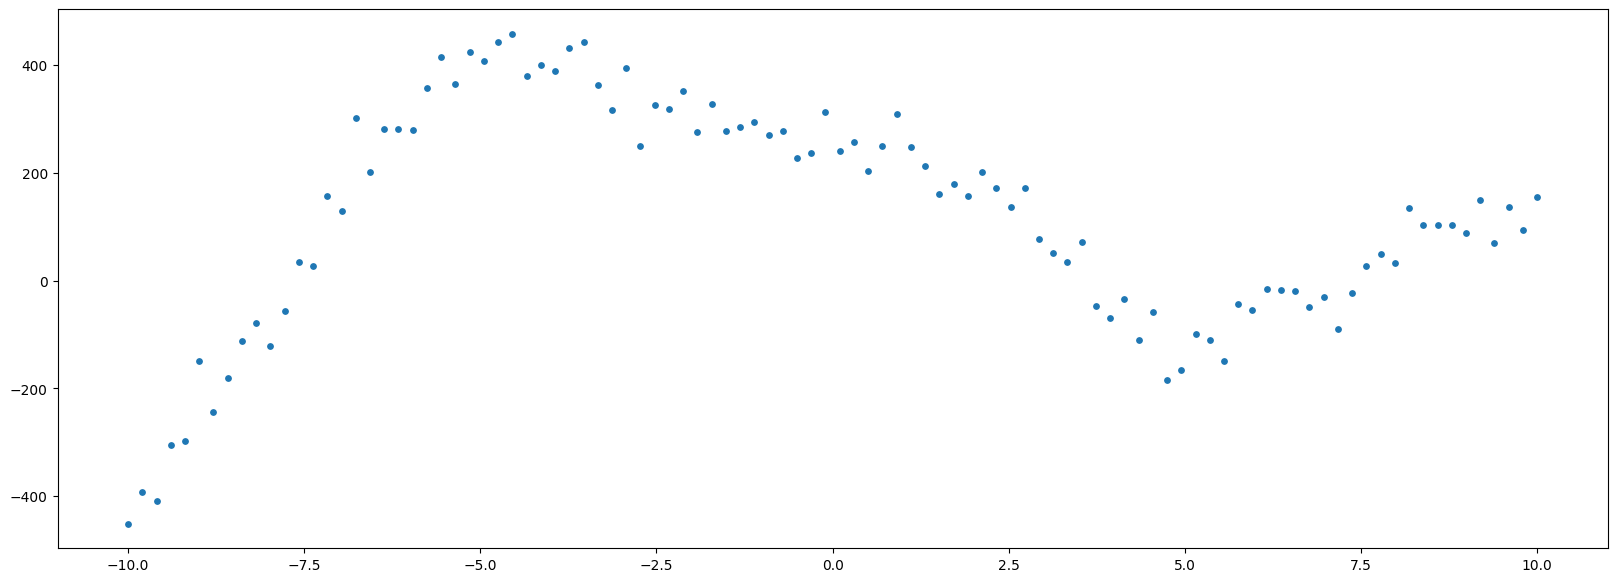

In [3]:
plt.figure(figsize = figsize)
plt.scatter(x, y, s = 15)
pass

$\large{X = \begin{bmatrix} x_1^3 & x_1^2 & x_1 & sin(x_1) & 1 \\ ... & ... & ... & ... & ...\\ x_m^3 & x_m^2 & x_m & sin(x_m) & 1 \end{bmatrix}}$

In [4]:
X = np.hstack([x**3, x**2, x, np.sin(x), np.ones(x.shape)])
print(X.shape)

(100, 5)


$\large{\theta = \begin{bmatrix} a \\ b \\ c \\ d \\ e\end{bmatrix}}$

In [5]:
theta = np.random.randn(X.shape[1], 1)
print(theta)

[[-0.56943806]
 [-0.78436412]
 [ 1.17040716]
 [ 0.1567465 ]
 [ 2.30786728]]


$\large{F = X.\theta}$

In [6]:
def model(X, theta):
    return X.dot(theta)

## Model vs real data

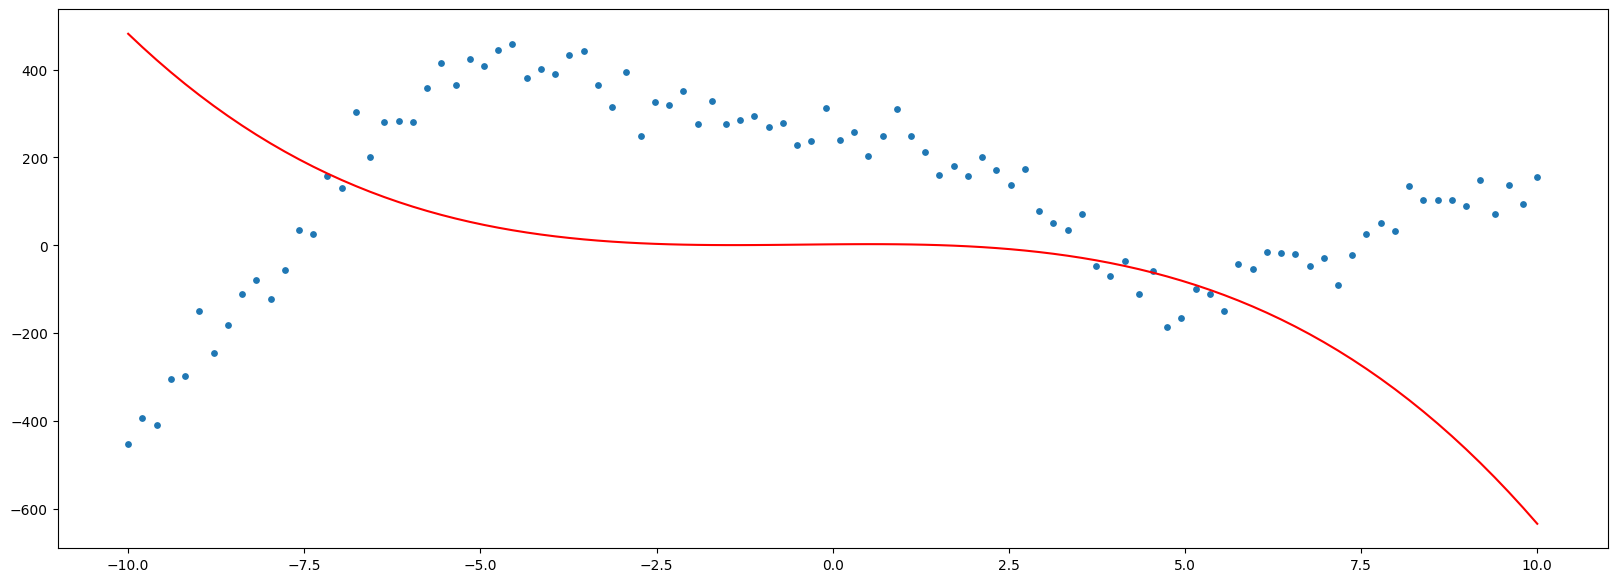

In [7]:
plt.figure(figsize = figsize)
plt.scatter(x, y, s = 15)
plt.plot(x, model(X, theta), c = 'r')
pass

$\large{\epsilon = F - y_i}$

In [8]:
def residuals(X, y, theta):
    return model(X, theta) - y

$\large{J(\theta) = \frac{1}{2m} \displaystyle\sum_{i=1}^m \epsilon^2}$

In [9]:
def loss_function(resi):
    return np.mean(resi**2) / 2

$\large{\frac{\partial J(\theta)}{\partial\theta} = \nabla_{\theta_t} J(\theta_{t,i}) = \frac{1}{m}X^T.\epsilon}$

In [10]:
def gradient(X, y, resi):
    return X.T.dot(resi) / len(y)

## Gradient descent

In [11]:
def descente_gradient(X, y, theta, learning_rate, epochs, batch_size, opti):
    loss_hist = np.zeros(epochs)
    nb_batches = len(y) // batch_size
    broke = False
    opt = opti(learning_rate)
    t = 0
    timestamp = time_ns()
    for i in range(epochs):
        for j in range(nb_batches):
            timestamp_delta = time_ns()
            if timestamp_delta - timestamp > 1e9:
                timestamp = timestamp_delta
                print(f'Epoch: {i}/{epochs} - Batch: {j}/{nb_batches}', end = '\r')
            lower_lim = j*batch_size
            higher_lim = lower_lim + batch_size
            mini_x = X[lower_lim:higher_lim]
            mini_y = y[lower_lim:higher_lim]
            resi = residuals(mini_x, mini_y, theta)
            t += 1
            new_theta = opt.updateTheta(mini_x, mini_y, resi, theta, t)
            if np.isnan(new_theta).any() or not np.isfinite(new_theta).all():
                broke = True
                break
            else:
                theta = new_theta
        if broke:
            print(f'Broke after {i} epochs')
            break
        else:
            loss_hist[i] = loss_function(residuals(X, y, theta))
        
    return theta, loss_hist

## GridSearch CV

In [12]:
def GridSearchCV(epochs, learning_rates, batch_sizes, opt):
    shape = np.array([learning_rates.size, batch_sizes.size])
    res = np.zeros(shape)
    losses = np.zeros([shape[0], shape[1], epochs])
    thetas = np.zeros([shape[0], shape[1], theta.shape[0], 1])
    for i, learning_rate in enumerate(learning_rates):
        for j, batch_size in enumerate(batch_sizes):
            print(f'Training LR: {i}/{shape[0]} = {learning_rate} - BS: {j}/{shape[1]} = {batch_size}')
            theta_final, loss_hist = descente_gradient(X, y, theta, learning_rate, epochs, batch_size, opt)
            thetas[i, j] = theta_final
            res[i, j] = coef_determination(y, model(X, theta_final))
            losses[i, j] = loss_hist
    print(f'Finished training LR: {shape[0]}/{shape[0]} - BS: {shape[1]}/{shape[1]}')
    
    return res, losses, thetas

### Tool to show the best hyper-parameters in a heat-map

In [13]:
def show_best_params(res, losses, learning_rates, batch_sizes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)

    im = ax1.imshow(res, extent = [0, batch_sizes.size, 0, learning_rates.size], cmap = 'hot')
    ax1.set_title('R^2')
    ax1.set_xlabel('Batch size')
    ax1.set_xticks(np.arange(0.5, batch_sizes.size + 0.5))
    ax1.set_xticklabels(batch_sizes)
    ax1.set_ylabel('Learning rate')
    ax1.set_yticks(np.arange(0.5, learning_rates.size + 0.5))
    ax1.set_yticklabels(np.flip(learning_rates))

    fig.colorbar(im, ax = ax1, shrink = 0.65)

    for i, l1 in enumerate(losses):
        for j, l2 in enumerate(l1):
            ax2.plot(l2, label = f'LR = {learning_rates[i]} | BS = {batch_sizes[j]}')
    ax2.set_title('Loss over epoch')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc = 'upper right')
    plt.show()
    
    args = np.unravel_index(losses.argmin(), losses.shape)
    theta_final = thetas[args[0], args[1]]
    pred = model(X, theta_final)
    print(f'theta: {theta_final.ravel()}')
    print(f'R : {coef_correlation(y, pred)}')
    print(f'R^2: {res[args[0], args[1]]}')
    print(f'Final loss: {losses[args[0], args[1]][-1]}')
    print(f'Meilleur eta: {learning_rates[args[0]]}')
    print(f'Meilleur batch_size: {batch_sizes[args[1]]}')
    
    return args, pred

### Only show best hyper-parameters vs real data

In [14]:
def show_best(args, losses, pred):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
    ax1.scatter(x, y, s = 15)
    ax1.plot(x, pred, c = 'r')
    ax1.set_title('Evolution de la population mondiale')
    ax1.set_xlabel('Année')
    ax1.set_ylabel('Population mondiale (en milliards)')

    ax2.plot(losses[args[0], args[1]])
    ax2.set_title('Evolution of loss during training')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    pass

## Adam

$\large{m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t}$

$\large{v_t = \beta_2 v_{t-1} + (1-\beta_2)g^2_t}$

Adam is biased towards zero soo we counteract the biases by computing bias-corrected moment

$\large{\hat{m}_t = \frac{m_t}{1 - \beta^t_1}}$

$\large{\hat{v}_t = \frac{v_t}{1 - \beta^t_2}}$

Finally

$\large{\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t}+\epsilon}\hat{m}_t}$

In [15]:
class Adam:
    def __init__(self, learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        self.m_t = 0
        self.v_t = 0
        
    def updateTheta(self, X, y, resi, theta, t):
        g = gradient(X, y, resi)
        self.m_t = self.beta_1 * self.m_t + (1 - self.beta_1) * g
        m_hat = self.m_t / (1 - self.beta_1 ** t)
        self.v_t = self.beta_2 * self.v_t + (1 - self.beta_2) * g**2
        v_hat = self.v_t / (1 - self.beta_2 ** t)
        
        grad = self.learning_rate / (np.sqrt(v_hat) + self.epsilon) * m_hat
        return theta - grad

## Coefficient of dertermination

$\large{R^2 = 1 - \frac{SSE}{SST} = 1 - \frac{\displaystyle\sum_{i=0}^m(y_i-\hat{y}_i)^2}{\displaystyle\sum_{i=0}^m(y_i-\bar{y})^2}}$

In [16]:
def coef_determination(y, pred):
    u = np.sum((y - pred)**2)
    v = np.sum((y - y.mean())**2)
    return 1 - u / v

## Coefficient of correlation (Person's correlation)

$\large{R = \frac{Cov(x,y)}{\sigma_x\sigma_y}}$

Note:

$Cov(X,Y) = \frac{1}{m}\displaystyle\sum_{i=1}^m(x_i - \bar{x})(y_i - \bar{y})$

$np.cov(a,b) = \begin{bmatrix} cov(a,a) & cov(a,b) \\ cov(a,b) & cov(b,b) \end{bmatrix}$

In [17]:
def coef_correlation(y, pred):
    cov = np.mean((y - y.mean()) * (pred - pred.mean()))
    #cov = np.cov(y.ravel(), pred.ravel(), bias = True)[0][1]
    v = y.std() * pred.std()
    return cov / v

# Testing with differents optimzations techniques using GridSearchCV

In [18]:
epochs = 250
learning_rates = np.array([10**-a for a in range(1, 3)])
batch_sizes = np.array([2**b for b in range(1, 4)])

## Testing Adam

In [19]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, Adam)

Training LR: 0/2 = 0.1 - BS: 0/3 = 2
Training LR: 0/2 = 0.1 - BS: 1/3 = 4
Training LR: 0/2 = 0.1 - BS: 2/3 = 8
Training LR: 1/2 = 0.01 - BS: 0/3 = 2
Training LR: 1/2 = 0.01 - BS: 1/3 = 4
Training LR: 1/2 = 0.01 - BS: 2/3 = 8
Finished training LR: 2/2 - BS: 3/3


### Showing best results

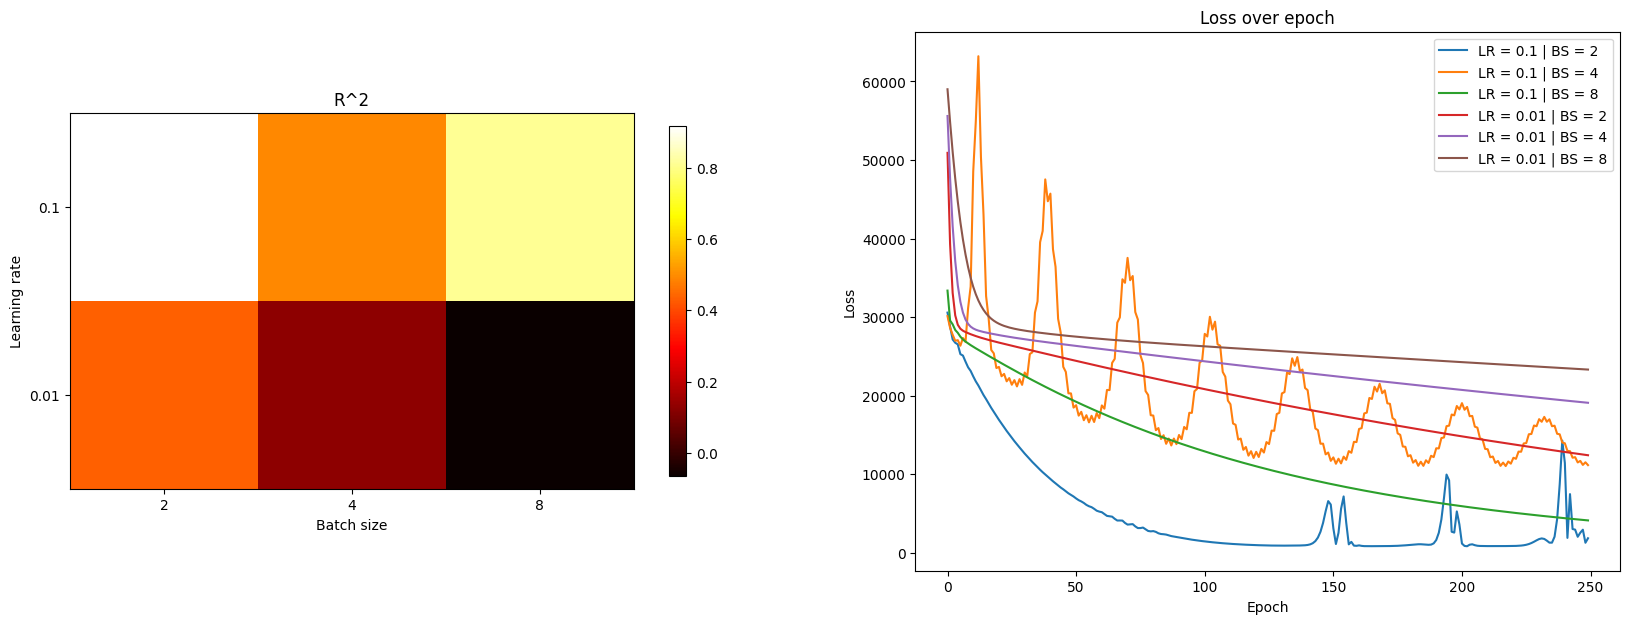

theta: [  0.87845802  -3.7292143  -64.51071192  66.09979811 258.2124201 ]
R : 0.9592760824892539
R^2: 0.9161791174207791
Final loss: 1835.3122061255083
Meilleur eta: 0.1
Meilleur batch_size: 2


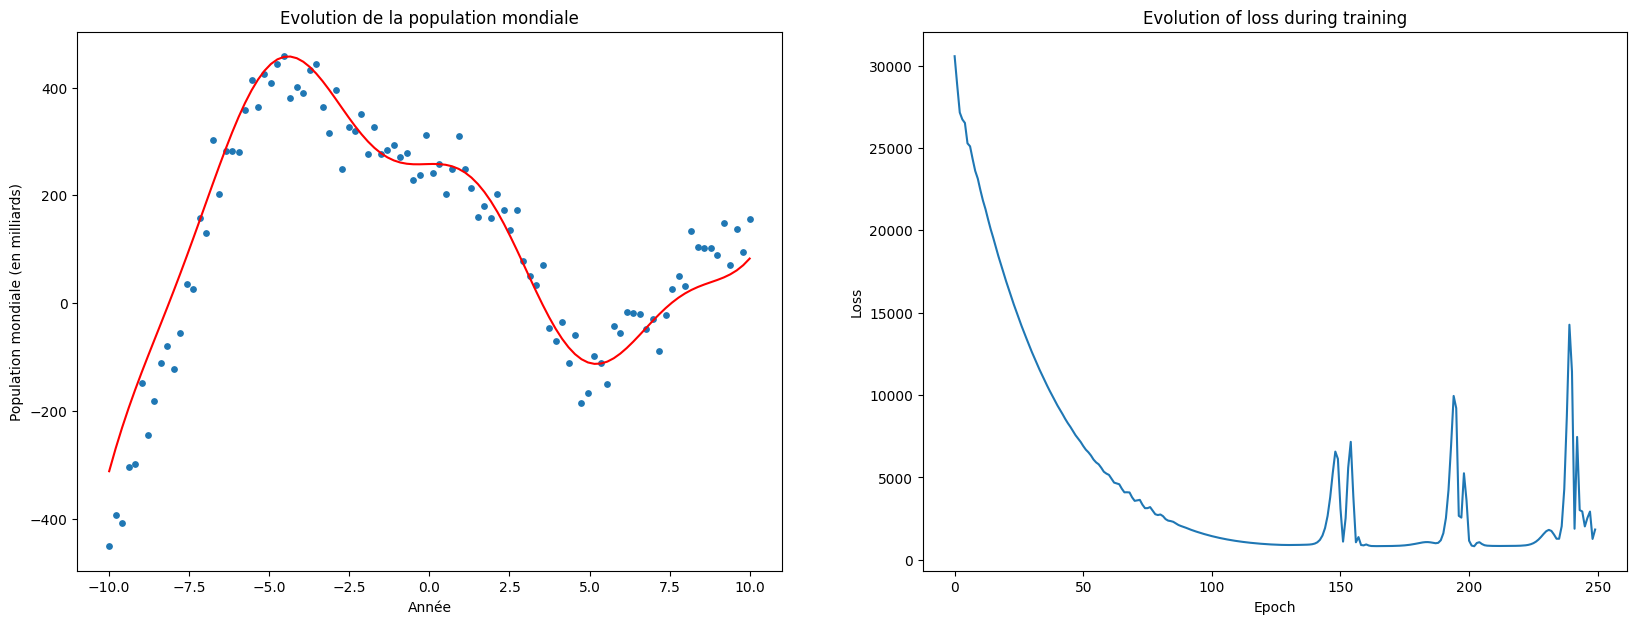

In [20]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

2020 Pierre Saunders